<a href="https://colab.research.google.com/github/Antoha2024/DiplomProductStar/blob/main/DS47_1_diabetes_ds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- train test split 70/30, stratified
- Random state  - 654321
- Метрика - F1 Macro
- Метрики на train и test не должны сильно отличаться

Гипотеза: Уровень глюкозы в крови оказывает влияние на вероятность заболевания диабетом.
Гипотеза нулевая (H0): Нет разницы в среднем значении уровня глюкозы у пациентов с диабетом и без диабета.
Альтернативная гипотеза (HА​): Существует значительная разница в среднем уровне глюкозы у пациентов с диабетом и без диабета. Дополинтельно провести сравнительный анализ количества значимых признаков на уровень глюкозы для пожилых людей и имеющим высокие показатели ИМТ для градации 1 и 2 типа сахарного диабета.
Методы проверки: t-тест, сравнение дисперсий.
- Работы команды:
https://colab.research.google.com/drive/1JbX1YjDkzM0qKy7I5EC4jHoqy75E5rAY?usp=sharing - Список по значимости влияния на целевую переменную.
https://colab.research.google.com/drive/1GE2EVPu5BuNlCPwcSOiIJsPPXpC4jp0o?usp=sharing#scrollTo=mwPuGptrEyw- - заполенение пробелов медианой и % пропусков.
- DS48 https://github.com/salfa-ru/ds41_50/blob/DS_48/DS48__diabetes_ds.ipynb

In [30]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, f_oneway
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")


In [2]:
uploaded = files.upload()
df = pd.read_excel('diabetes_ds.xlsx')
#Переименование таргета, удаление в нём пропусков
df = df.rename(columns={r'Сахарный диабет (ЕСТЬ\НЕТ)' : 'Сахарный диабет'})
df = df.dropna(subset = ['Сахарный диабет']).reset_index(drop=True)
display(df.head(3), df.shape)

Saving diabetes_ds.xlsx to diabetes_ds.xlsx


,Номер,Перенес/ не перенес КВИ,Возраст,Пол,"Рост, см","Вес, кг",ИМТ 2 (ФОРМУЛА EXCEL),Эритроциты,Гемоглобин,Цветовой показатель,...,ИБС. ПИКС,ИБС. ПИКС (ЕСТЬ\НЕТ),"АГ, стадия",АГ (ЕСТЬ\НЕТ),"АГ, степень","АГ, риск","ХСН, стадии","ХСН, ФК","ХСН по фракции выброса, %",Сахарный диабет
0,390.0,1.0,68.0,2.0,158.0,86.0,34.449607,5.33,163.0,0.0,...,1.0,1.0,3.0,1.0,3.0,4.0,2.0,2.0,0,1.0
1,337.0,1.0,54.0,1.0,180.0,119.0,36.728395,5.01,130.0,0.0,...,1.0,1.0,3.0,1.0,3.0,4.0,2.0,3.0,35,1.0
2,160.0,1.0,68.0,1.0,174.0,110.0,36.332409,NaN,161.0,0.0,...,1.0,1.0,3.0,1.0,3.0,4.0,3.0,3.0,35,1.0


(478, 108)

In [3]:
df.info() #общая статистика

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Columns: 108 entries, Номер to Сахарный диабет
dtypes: float64(101), object(7)
memory usage: 403.4+ KB


In [4]:
#Показать список столбцов полностью
pd.set_option('display.max_rows', None)
print(df.dtypes)

Номер                                                                    float64
Перенес/ не перенес КВИ                                                  float64
Возраст                                                                  float64
Пол                                                                      float64
Рост, см                                                                 float64
Вес, кг                                                                  float64
ИМТ 2 (ФОРМУЛА EXCEL)                                                    float64
Эритроциты                                                               float64
Гемоглобин                                                               float64
Цветовой показатель                                                      float64
Лейкоциты                                                                float64
Лимфоциты%                                                               float64
ЛИМФОЦИТЫ, АБС (РАСЧЕТ ПО ФО

In [5]:
#Столбцы которые содержат пробелы
has_space = df.applymap(lambda x: isinstance(x, str) and ' ' in x).any()
space_columns = has_space[has_space].index
print(space_columns)

Index(['Гипертрофия миокарда левого желудочка по ЭКГ или ЭХО-КГ (комментарий)',
       'Блокада НП Гисса (комментарий)', 'ХБП (исходн)'],
      dtype='object')


In [6]:
#Столбцы с типом object
obj_columns = df.columns[df.dtypes == 'object']
print(obj_columns)

Index(['BPB голеней',
       'Гипертрофия миокарда левого желудочка по ЭКГ или ЭХО-КГ (комментарий)',
       'Блокада НП Гисса', 'Блокада НП Гисса (комментарий)', 'AV- блокада',
       'ХБП (исходн)', 'ХСН по фракции выброса, %'],
      dtype='object')


Пустых значений: 0
Сахарный диабет
1.0    255
0.0    223
Name: count, dtype: int64


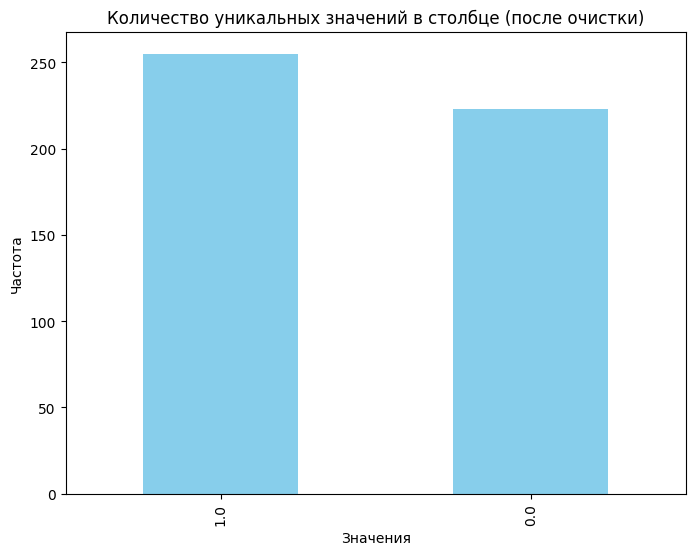

In [7]:
# Подсчет уникальных значений
value_counts = df['Сахарный диабет'].value_counts(dropna=False)

# Подсчет пустых значений
missing_count = df['Сахарный диабет'].isnull().sum()
print(f"Пустых значений: {missing_count}")

# Удаление строк с пустыми значениями
df_cleaned = df.dropna(subset=['Сахарный диабет'])

# Визуализация оставшихся данных
clean_value_counts = df_cleaned['Сахарный диабет'].value_counts()

# Печать очищенных данных
print(clean_value_counts)

# Построение графика
plt.figure(figsize=(8, 6))
clean_value_counts.plot(kind='bar', color='skyblue')
plt.title('Количество уникальных значений в столбце (после очистки)')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.show()

Вывод: Оценивая представленную информацию, можно сказать, что в наборе данных наблюдается умеренный дисбаланс классов:

Класс 1.0 («есть сахарный диабет») присутствует в количестве 255 случаев.
Класс 0.0 («нет сахарного диабета») составляет 223 случая.
Соотношение классов составляет примерно:

$$\frac{223}{255} \approx 1.14$$

То есть класс 1.0 представлен немного чаще, но дисбаланс невелик. Такой уровень дисбаланса считается приемлемым и не требует специальных мер по восстановлению равновесия классов.

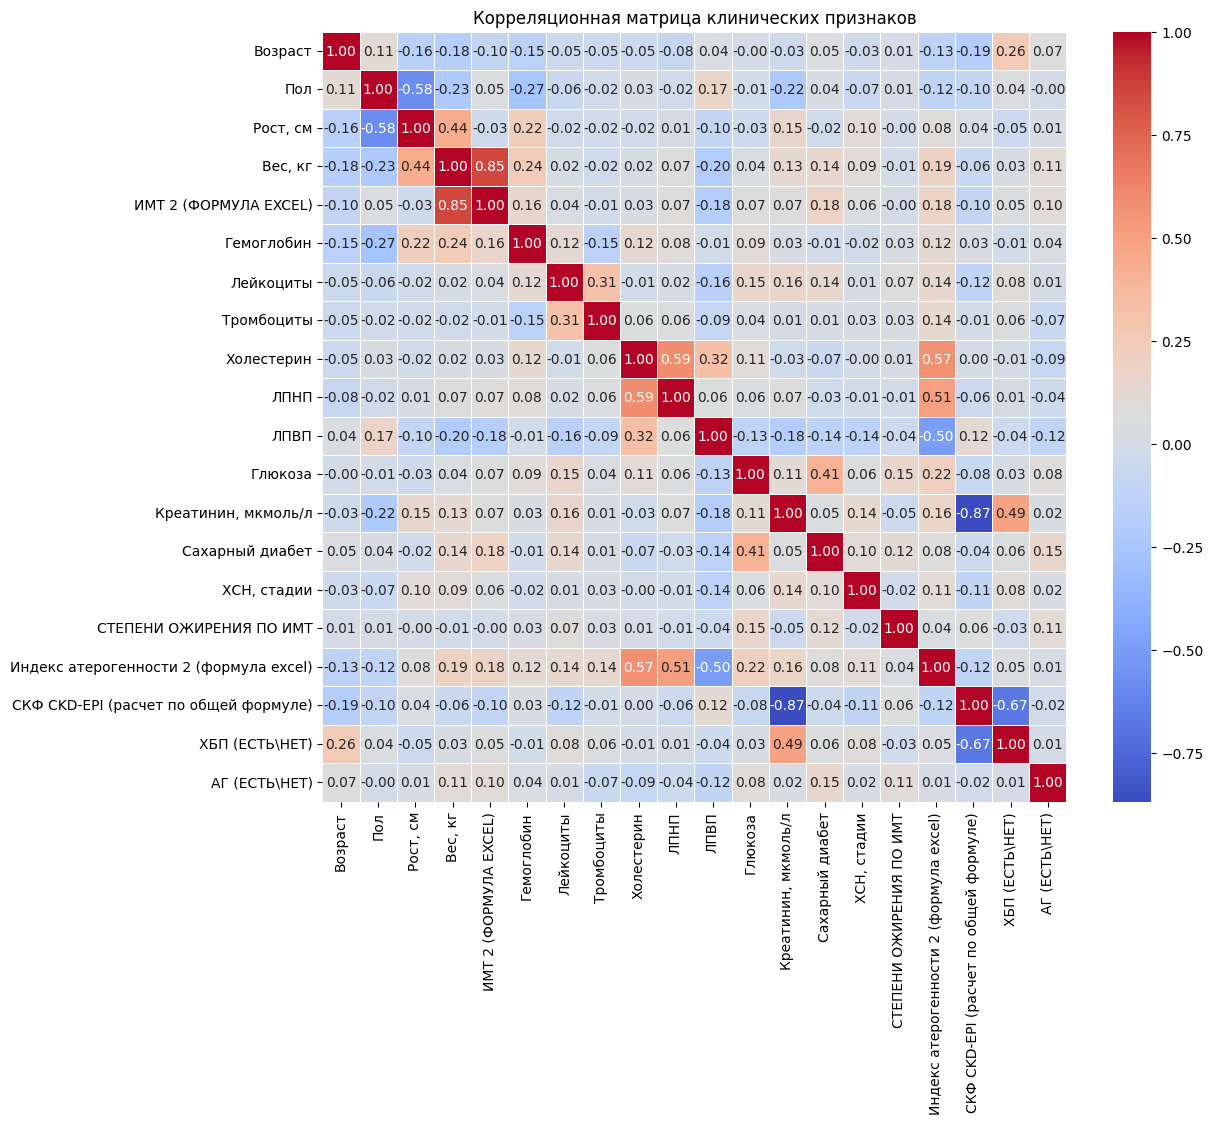

In [8]:
#расчет показателей группы пациентов с повышенной группой риска
clinical_cols = [
    "Возраст",
    "Пол",
    "Рост, см",
    "Вес, кг",
    "ИМТ 2 (ФОРМУЛА EXCEL)",
    "Гемоглобин",
    "Лейкоциты",
    "Тромбоциты",
    "Холестерин",
    "ЛПНП",
    "ЛПВП",
    "Глюкоза",
    "Креатинин, мкмоль/л",
    "Сахарный диабет",
    "ХСН, стадии",
    "СТЕПЕНИ ОЖИРЕНИЯ ПО ИМТ",
    "Индекс атерогенности 2 (формула excel)",
    "СКФ CKD-EPI (расчет по общей формуле)",
    "ХБП (ЕСТЬ\\НЕТ)",
    "АГ (ЕСТЬ\\НЕТ)"
]

# Остаемся только с нужными признаками
selected_df = df[clinical_cols].copy()

# Замещаем NaN-значения на медианы соответствующего столбца
for column in clinical_cols:
    if selected_df[column].dtype != 'O':  # исключаем категориальные переменные
        median_value = selected_df[column].median()
        selected_df[column].fillna(median_value, inplace=True)

# Матрица корреляции
corr_matrix = selected_df.corr()

# Рисуем тепловую карту
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt='.2f', linewidths=.5)
plt.title("Корреляционная матрица клинических признаков")
plt.show()

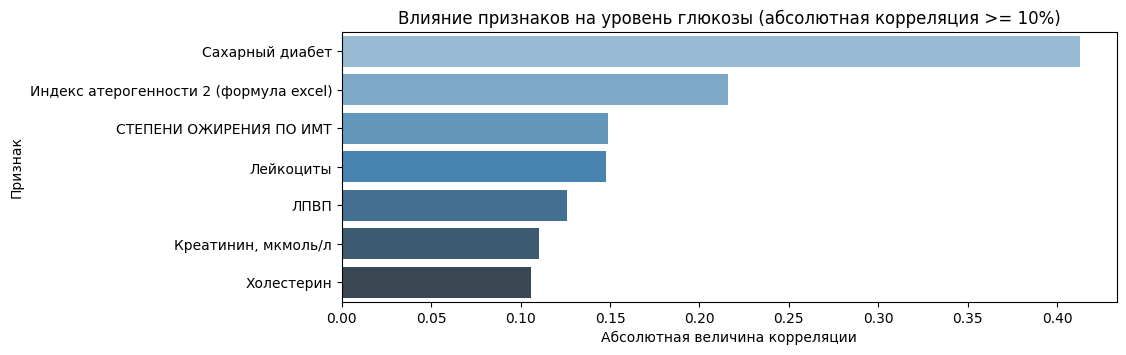

In [9]:
# Исходный список признаков
clinical_cols = [
    "Возраст",
    "Пол",
    "Рост, см",
    "Вес, кг",
    "ИМТ 2 (ФОРМУЛА EXCEL)",
    "Гемоглобин",
    "Лейкоциты",
    "Тромбоциты",
    "Холестерин",
    "ЛПНП",
    "ЛПВП",
    "Глюкоза",
    "Креатинин, мкмоль/л",
    "Сахарный диабет",
    "ХСН, стадии",
    "СТЕПЕНИ ОЖИРЕНИЯ ПО ИМТ",
    "Индекс атерогенности 2 (формула excel)",
    "СКФ CKD-EPI (расчет по общей формуле)",
    "ХБП (ЕСТЬ\\НЕТ)",
    "АГ (ЕСТЬ\\НЕТ)"
]

# Берём только интересующие нас признаки
selected_df = df[clinical_cols].copy()

# Замещаем пропуски медианой
for column in clinical_cols:
    if selected_df[column].dtype != 'O':
        median_value = selected_df[column].median()
        selected_df[column].fillna(median_value, inplace=True)

# Вычислим корреляцию
corr_matrix = selected_df.corr()

# Получим корреляцию по отношению к глюкозе
glucose_corr = corr_matrix['Глюкоза'].abs().sort_values(ascending=False)[1:]  # игнорируем само себя (корреляция 1.0)

# Отберём только признаки с абсолютной силой корреляции >= 10%
significant_features = glucose_corr[glucose_corr >= 0.1]

# Создание графика (горизонтальная гистограмма)
plt.figure(figsize=(10, len(significant_features)*0.5))  # высота зависит от количества признаков
sns.barplot(x=significant_features.values, y=significant_features.index, palette="Blues_d")
plt.xlabel("Абсолютная величина корреляции")
plt.ylabel("Признак")
plt.title("Влияние признаков на уровень глюкозы (абсолютная корреляция >= 10%)")
plt.show()

Вывод: В списке по влиянию на показатели глюкозы попали пациенты с высокой степенью ожирения, группа пожилых пациентов не попала возможно из-за большого количества пропусков.

In [15]:
# Исходный список признаков
clinical_cols = [
    "Возраст",
    "Пол",
    "Рост, см",
    "Вес, кг",
    "ИМТ 2 (ФОРМУЛА EXCEL)",
    "Гемоглобин",
    "Лейкоциты",
    "Тромбоциты",
    "Холестерин",
    "ЛПНП",
    "ЛПВП",
    "Глюкоза",
    "Креатинин, мкмоль/л",
    "Сахарный диабет",
    "ХСН, стадии",
    "СТЕПЕНИ ОЖИРЕНИЯ ПО ИМТ",
    "Индекс атерогенности 2 (формула excel)",
    "СКФ CKD-EPI (расчет по общей формуле)",
    "ХБП (ЕСТЬ\\НЕТ)",
    "АГ (ЕСТЬ\\НЕТ)"
]

# Берём только интересующие нас признаки
selected_df = df[clinical_cols].copy()

# Целевая переменная — наличие сахарного диабета
target_col = 'Сахарный диабет'
X = selected_df.drop(target_col, axis=1)
y = selected_df[target_col]

# Разделение на тренировочные и тестовые выборки (70/30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=654321)

# Заполняем пустые значения медианой отдельно в тренировочной и тестовой выборках
for column in X_train.columns:
    if X_train[column].dtype != 'object':
        median_value_train = X_train[column].median()
        X_train[column].fillna(median_value_train, inplace=True)

        median_value_test = X_test[column].median()
        X_test[column].fillna(median_value_test, inplace=True)

# Масштабируем признаки
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [62]:
# Создание и обучение модели Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=654321)
rf_model.fit(X_train_scaled, y_train)

# Извлечение значений важности признаков
feature_importances = rf_model.feature_importances_

# Сохраняем названия признаков
features_names = X.columns.tolist()

# Формируем DataFrame для наглядности
importance_df = pd.DataFrame({
    'Feature': features_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)
top_feature = importance_df.iloc[:10]

# Печать таблицы с признаками и уровнем их важности
print("Рейтинг признаков по влиянию на сахарный диабет:")
display(importance_df[:11])


Рейтинг признаков по влиянию на сахарный диабет:


,Feature,Importance
0,Глюкоза,0.248971
1,Лейкоциты,0.063587
2,ИМТ 2 (ФОРМУЛА EXCEL),0.061281
3,ЛПНП,0.058318
4,Индекс атерогенности 2 (формула excel),0.055272
5,ЛПВП,0.055195
6,"Креатинин, мкмоль/л",0.055095
7,Холестерин,0.054742
8,Гемоглобин,0.053065
9,"Вес, кг",0.052401


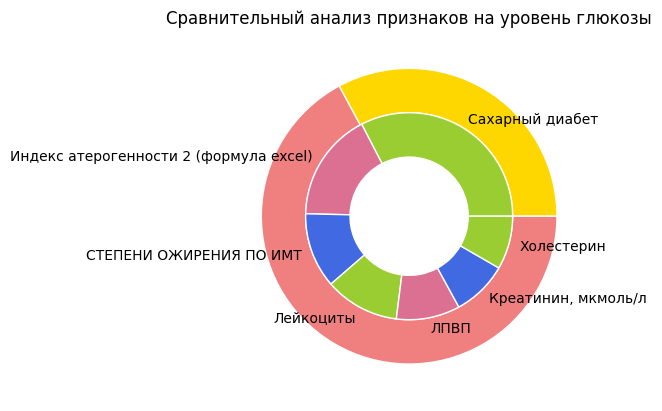

In [65]:
# Выберите семь главных признаков (количество совпадает с длиной significant_features)
top_feature = importance_df.iloc[:10]

# Фильтруем признаки с высоким влиянием на глюкозу
significant_features = glucose_corr[glucose_corr >= 0.1]

# Имена признаков берем из индекса Series
labels = significant_features.index.to_list()

# Сами значения важности
sizes = significant_features.values
sizes_1 = top_feature['Importance'].values

# Многослойная круговая диаграмма
fig, ax = plt.subplots()

# Устанавливаем размер внешнего кольца
size = 0.3

# Определяем цвета для слоев
outer_colors = ['gold', 'lightcoral', 'lightskyblue']
inner_colors = ['yellowgreen', 'palevioletred', 'royalblue']

# Наружное кольцо (суммарная доля первой половины признаков)
ax.pie([np.sum(sizes_1[:1]), np.sum(sizes_1[1:])], radius=1, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'), labels=['', ''])

# Внутреннее кольцо (детализация долей признаков)
ax.pie(sizes, radius=1-size, colors=inner_colors,
       wedgeprops=dict(width=size, edgecolor='w'), labels=labels)

ax.set_aspect("equal")
plt.title('Cравнительный анализ признаков на уровень глюкозы', fontsize=12)
plt.show()

In [12]:
# Обучаем модель Random Forest
rf_model = RandomForestClassifier(random_state=654321)
rf_model.fit(X_train_scaled, y_train)

# Прогноз на тестовом наборе
y_pred = rf_model.predict(X_test_scaled)

# Отчёт по классификации
report = classification_report(y_test, y_pred)
print(report)

# F1-macro score
macro_f1 = f1_score(y_test, y_pred, average='macro')
print(f"F1-macro Score: {macro_f1:.4f}")

              precision    recall  f1-score   support

         0.0       0.72      0.75      0.74        67
         1.0       0.77      0.75      0.76        77

    accuracy                           0.75       144
   macro avg       0.75      0.75      0.75       144
weighted avg       0.75      0.75      0.75       144

F1-macro Score: 0.7492
